In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sys
#path_to_mavenn = '/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn'
path_to_mavenn = '/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_git_ssh/'
sys.path.insert(0,path_to_mavenn)

# Load mavenn
import mavenn

In [2]:
number_of_double_mutants_used_to_train_val_test_subsampled_model = 50000
gb1_wt_sequence = 'QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE'

# Load example data (WHICH CONTAINS DOUBLE MUTANTS ONLY!)
data_df = mavenn.load_example_dataset('gb1')

# Separate test from data_df
ix_test = data_df['set']=='test'
test_df = data_df[ix_test].reset_index(drop=True)
print(f'test N: {len(test_df):,}')

# Remove test data from data_df
data_df = data_df[~ix_test].reset_index(drop=True)
print(f'training + validation N: {len(data_df):,}')
data_df.head(10)

test N: 26,364
training + validation N: 504,373


,set,dist,input_ct,selected_ct,y,x
0,training,2,173,33,-3.145154,AAKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
1,training,2,18,8,-1.867676,ACKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
2,training,2,66,2,-5.270800,ADKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
3,training,2,72,1,-5.979498,AEKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
4,training,2,69,168,0.481923,AFKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
5,training,2,108,1,-6.557858,AGKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
6,training,2,48,93,0.150206,AHKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
7,training,2,119,49,-2.052708,AIKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
8,training,2,252,79,-2.450739,ALKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
9,training,2,110,116,-0.713724,AMKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...


In [3]:
# raw single mutants data from the Gb1 paper. 
GB1_data_single_mutants = pd.read_csv('data/oslon_data_single_mutants_ambler.csv')
GB1_data_single_mutants.head()

,WT amino acid,Position,Mutation,Input Count,Selection Count
0,Q,2,A,14663,38476
1,Q,2,C,13001,23023
2,Q,2,D,11488,18085
3,Q,2,E,9501,15629
4,Q,2,F,4770,13332


In [4]:
def load_olson_data_GB1():

    """
    Helper function to turn single mutant data provided by 
    Olson et al. into sequence-values arrays. 

    return
    ------
    gb1_df: (pd dataframe)
        dataframe containing sequences (single)
        and their corresponding log2 enrichment values.
        pseudo count of 1 is added to numerator and 
        denominator.

    """

    # GB1 WT sequences
    WT_seq = 'QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE'

    # WT sequence library and selection counts.
    WT_input_count = 1759616
    WT_selection_count = 3041819
    
    # lists that will contain sequences and their values
    sequences = []
    enrichment = []
    
    # load single mutants data
    oslon_single_mutant_positions_data = pd.read_csv('data/oslon_data_single_mutants_ambler.csv',
                                                     na_values="nan")

    for loop_index in range(len(oslon_single_mutant_positions_data)):
        mut_index = int(oslon_single_mutant_positions_data['Position'][loop_index]) - 2

        mut = oslon_single_mutant_positions_data['Mutation'][loop_index]

        temp_seq = list(WT_seq)
        temp_seq[mut_index] = mut

        # calculate enrichment for sequence
        input_count = oslon_single_mutant_positions_data['Input Count'][loop_index]
        selection_count = oslon_single_mutant_positions_data['Selection Count'][loop_index]
        # added pseudo count to ensure log doesn't throw up
        temp_fitness = ((selection_count + 1) / (input_count+1)) / (WT_selection_count / WT_input_count)

        sequences.append(''.join(temp_seq))
        enrichment.append(temp_fitness)    

    enrichment = np.array(enrichment).copy()

    gb1_df = pd.DataFrame({'x': sequences, 'y': np.log2(enrichment)}, columns=['x', 'y'])
    return gb1_df

gb1_single_mutants_df = load_olson_data_GB1()

In [5]:
# data frame containing all single mutant
# sequences and their log2 enrichment.
# Include these for training.
gb1_single_mutants_df.head()

,x,y
0,AYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...,0.602044
1,CYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...,0.034731
2,DYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...,-0.135054
3,EYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...,-0.071659
4,FYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...,0.692964


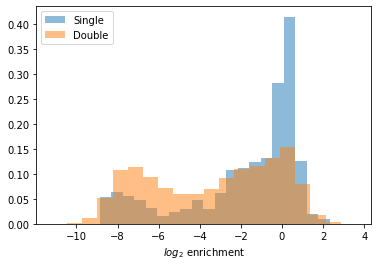

In [6]:
plt.hist(gb1_single_mutants_df['y'].values,density=True,alpha=0.5,bins=20,label='Single')
plt.hist(data_df['y'].values,density=True,alpha=0.5,bins=20,label='Double')
plt.legend()
plt.xlabel('$log_2$ enrichment')
plt.show()

# Subsample double mutants

In [7]:
from numpy.random import default_rng

# number of double mutant sequences are 530737
rng = default_rng()
# size here represents the number of double mutants
# uniformly randomly pick some number of double mutants


numbers = rng.choice(len(data_df), size=number_of_double_mutants_used_to_train_val_test_subsampled_model, replace=False) 


In [8]:
gb1_double_mutants_df = data_df.loc[numbers].reset_index(drop=True).copy()

In [9]:
gb1_double_mutants_df.head()

,set,dist,input_ct,selected_ct,y,x
0,training,2,166,2,-6.588415,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYAHDNGVDGEWTYAD...
1,validation,2,4001,3096,-1.159523,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWIYDD...
2,training,2,125,2,-6.181991,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEGTYDD...
3,training,2,824,64,-4.455556,QYKSILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
4,training,2,352,864,0.503359,QYVLILNGKTLKGTTTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...


In [10]:


# # Separate test from data_df
# ix_test = gb1_double_mutants_df['set']=='test'
# test_df = gb1_double_mutants_df[ix_test].reset_index(drop=True)
# print(f'test N: {len(test_df):,}')

# Remove test data from data_df
gb1_double_mutants_df_train = gb1_double_mutants_df.copy().reset_index(drop=True)
print(f'double mutant training + validation N: {len(gb1_double_mutants_df_train):,}')
gb1_double_mutants_df_train.head()


double mutant training + validation N: 50,000


,set,dist,input_ct,selected_ct,y,x
0,training,2,166,2,-6.588415,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYAHDNGVDGEWTYAD...
1,validation,2,4001,3096,-1.159523,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWIYDD...
2,training,2,125,2,-6.181991,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEGTYDD...
3,training,2,824,64,-4.455556,QYKSILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
4,training,2,352,864,0.503359,QYVLILNGKTLKGTTTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...


In [11]:
# format single mutant df to look like double mutant df
gb1_single_mutants_df['set']='training'

In [12]:
gb1_single_mutants_df[['set','y','x']].head()

,set,y,x
0,training,0.602044,AYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
1,training,0.034731,CYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
2,training,-0.135054,DYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
3,training,-0.071659,EYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
4,training,0.692964,FYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...


In [13]:
# merge single mutants df and subsampled double mutants df
gb1_subsampled_df = gb1_single_mutants_df[['set','y','x']].append(gb1_double_mutants_df[['set','y','x']], ignore_index=True)

In [14]:
# Get sequence length
L = len(data_df['x'][0])

# Define model
model = mavenn.Model(regression_type='GE',
                     L=L,
                     alphabet='protein',
                     gpmap_type='additive',                     
                     ge_noise_model_type='Gaussian',
                     ge_heteroskedasticity_order=2)

In [15]:
# Set training data
model.set_data(x=gb1_subsampled_df['x'],
               y=gb1_subsampled_df['y'],
               validation_flags=(gb1_subsampled_df['set']=='validation'),
               shuffle=True)

N = 51,045 observations set as training data.
Using 5.3% for validation.
Data shuffled.
Time to set data: 1.8 sec.


In [16]:
# Fit model to data
history = model.fit(learning_rate=.00005,
                    epochs=1000,
                    batch_size=50,
                    early_stopping=True,
                    early_stopping_patience=15,
                    linear_initialization=True)

Using TensorFlow backend.
Exception ignored in: <bound method tqdm.__del__ of <tqdm.auto.tqdm object at 0x7f8e11a90eb8>>
Traceback (most recent call last):
  File "/Users/tareen/miniconda3/lib/python3.6/site-packages/tqdm/std.py", line 1147, in __del__
    self.close()
  File "/Users/tareen/miniconda3/lib/python3.6/site-packages/tqdm/notebook.py", line 289, in close
    self.disp(bar_style='success', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


 
LSMR            Least-squares solution of  Ax = b

The matrix A has    48352 rows  and     1100 cols
damp = 0.00000000000000e+00

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =     1100

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  2.199e+02  7.664e+03   1.0e+00  1.6e-01
     1  2.85237e-04  2.187e+02  7.631e+03   9.9e-01  7.9e-01  4.4e+01  1.0e+00
     2  3.66210e-02  1.243e+02  9.485e+02   5.7e-01  4.9e-03  1.6e+03  3.5e+00
     3  3.54620e-02  1.188e+02  8.464e+02   5.4e-01  4.5e-03  1.6e+03  3.1e+01
     4  3.36024e-02  8.213e+01  2.105e+02   3.7e-01  1.6e-03  1.6e+03  4.0e+01
     5  3.43710e-02  8.176e+01  1.075e+02   3.7e-01  8.4e-04  1.6e+03  3.9e+01
     6  3.43763e-02  8.176e+01  1.066e+02   3.7e-01  8.2e-04  1.6e+03  3.9e+01
     7  4.07634e-02  8.132e+01  8.483e+01   3.7e-01  4.7e-04  2.2e+03  1.6e+02
     8  5.23103e-02  8.096e+01  2.271e+01   3.7e-01  1.3e-04  2.2e+03  1.3

968/968 [==============================] - 1s 1ms/step - loss: -8.5492 - I_var: 2.0645 - val_loss: -5.9341 - val_I_var: 1.9763
Epoch 48/1000
968/968 [==============================] - 1s 1ms/step - loss: -8.9386 - I_var: 2.0659 - val_loss: -5.7372 - val_I_var: 1.9705
Epoch 49/1000
968/968 [==============================] - 1s 1ms/step - loss: -9.2182 - I_var: 2.0661 - val_loss: -5.8948 - val_I_var: 1.9749
Epoch 50/1000
968/968 [==============================] - 1s 1ms/step - loss: -9.3486 - I_var: 2.0687 - val_loss: -5.4708 - val_I_var: 1.9626
Epoch 51/1000
968/968 [==============================] - 1s 1ms/step - loss: -9.2099 - I_var: 2.0699 - val_loss: -6.0846 - val_I_var: 1.9801
Epoch 52/1000
968/968 [==============================] - 1s 1ms/step - loss: -9.1680 - I_var: 2.0723 - val_loss: -6.1420 - val_I_var: 1.9816
Epoch 53/1000
968/968 [==============================] - 1s 1ms/step - loss: -9.0160 - I_var: 2.0726 - val_loss: -6.0276 - val_I_var: 1.9781
Epoch 54/1000
968/968 [====

968/968 [==============================] - 1s 1ms/step - loss: -9.9965 - I_var: 2.0866 - val_loss: -7.1144 - val_I_var: 1.9998
Epoch 106/1000
968/968 [==============================] - 1s 1ms/step - loss: -9.7268 - I_var: 2.0882 - val_loss: -7.3270 - val_I_var: 2.0057
Epoch 107/1000
968/968 [==============================] - 1s 1ms/step - loss: -10.2864 - I_var: 2.0890 - val_loss: -7.2120 - val_I_var: 2.0022
Epoch 108/1000
968/968 [==============================] - 1s 1ms/step - loss: -10.4256 - I_var: 2.0883 - val_loss: -7.2656 - val_I_var: 2.0035
Epoch 109/1000
968/968 [==============================] - 1s 1ms/step - loss: -10.4382 - I_var: 2.0884 - val_loss: -7.2935 - val_I_var: 2.0041
Epoch 110/1000
968/968 [==============================] - 1s 1ms/step - loss: -10.1332 - I_var: 2.0890 - val_loss: -7.3089 - val_I_var: 2.0044
Epoch 111/1000
968/968 [==============================] - 1s 1ms/step - loss: -10.0363 - I_var: 2.0869 - val_loss: -7.2864 - val_I_var: 2.0036
Epoch 112/1000
9

968/968 [==============================] - 1s 1ms/step - loss: -10.7231 - I_var: 2.0914 - val_loss: -7.6041 - val_I_var: 2.0076
Epoch 163/1000
968/968 [==============================] - 1s 1ms/step - loss: -11.0695 - I_var: 2.0902 - val_loss: -7.6325 - val_I_var: 2.0083
Epoch 164/1000
968/968 [==============================] - 1s 1ms/step - loss: -10.0560 - I_var: 2.0890 - val_loss: -7.6866 - val_I_var: 2.0098
Epoch 165/1000
968/968 [==============================] - 1s 1ms/step - loss: -10.6419 - I_var: 2.0914 - val_loss: -7.7090 - val_I_var: 2.0103
Epoch 166/1000
968/968 [==============================] - 1s 1ms/step - loss: -10.4644 - I_var: 2.0897 - val_loss: -7.6270 - val_I_var: 2.0079
Epoch 167/1000
968/968 [==============================] - 1s 1ms/step - loss: -10.3056 - I_var: 2.0904 - val_loss: -7.6524 - val_I_var: 2.0086
Epoch 168/1000
968/968 [==============================] - 1s 1ms/step - loss: -10.6896 - I_var: 2.0912 - val_loss: -7.6143 - val_I_var: 2.0074
Epoch 169/1000

968/968 [==============================] - 1s 1ms/step - loss: -10.5520 - I_var: 2.0928 - val_loss: -7.8737 - val_I_var: 2.0103
Epoch 220/1000
968/968 [==============================] - 1s 1ms/step - loss: -10.8265 - I_var: 2.0929 - val_loss: -7.7410 - val_I_var: 2.0064
Epoch 221/1000
968/968 [==============================] - 1s 1ms/step - loss: -11.1069 - I_var: 2.0920 - val_loss: -7.9326 - val_I_var: 2.0118
Epoch 222/1000
968/968 [==============================] - 2s 2ms/step - loss: -10.3596 - I_var: 2.0928 - val_loss: -7.8952 - val_I_var: 2.0107
Epoch 223/1000
968/968 [==============================] - 1s 1ms/step - loss: -10.8064 - I_var: 2.0930 - val_loss: -7.9718 - val_I_var: 2.0128
Epoch 224/1000
968/968 [==============================] - 1s 1ms/step - loss: -10.8265 - I_var: 2.0907 - val_loss: -7.8953 - val_I_var: 2.0105
Epoch 225/1000
968/968 [==============================] - 1s 1ms/step - loss: -10.5475 - I_var: 2.0924 - val_loss: -7.9451 - val_I_var: 2.0118
Epoch 226/1000

968/968 [==============================] - 1s 1ms/step - loss: -10.4413 - I_var: 2.0932 - val_loss: -8.1122 - val_I_var: 2.0133
Epoch 277/1000
968/968 [==============================] - 1s 1ms/step - loss: -10.2739 - I_var: 2.0926 - val_loss: -8.0227 - val_I_var: 2.0107
Epoch 278/1000
968/968 [==============================] - 1s 1ms/step - loss: -10.6951 - I_var: 2.0943 - val_loss: -8.1113 - val_I_var: 2.0133
Epoch 279/1000
968/968 [==============================] - 1s 1ms/step - loss: -11.3439 - I_var: 2.0921 - val_loss: -7.9929 - val_I_var: 2.0098
Epoch 280/1000
968/968 [==============================] - 1s 1ms/step - loss: -10.8707 - I_var: 2.0922 - val_loss: -8.0470 - val_I_var: 2.0113
Epoch 281/1000
968/968 [==============================] - 1s 1ms/step - loss: -10.8648 - I_var: 2.0931 - val_loss: -8.1079 - val_I_var: 2.0130
Epoch 282/1000
968/968 [==============================] - 1s 1ms/step - loss: -10.8799 - I_var: 2.0920 - val_loss: -8.1329 - val_I_var: 2.0137
Epoch 283/1000

968/968 [==============================] - 1s 1ms/step - loss: -11.1736 - I_var: 2.0938 - val_loss: -8.1593 - val_I_var: 2.0127
Epoch 334/1000
968/968 [==============================] - 1s 1ms/step - loss: -10.9273 - I_var: 2.0926 - val_loss: -8.1575 - val_I_var: 2.0126
Epoch 335/1000
968/968 [==============================] - 1s 1ms/step - loss: -10.9702 - I_var: 2.0927 - val_loss: -8.2027 - val_I_var: 2.0138
Epoch 336/1000
968/968 [==============================] - 1s 1ms/step - loss: -10.7060 - I_var: 2.0895 - val_loss: -8.2092 - val_I_var: 2.0140
Epoch 337/1000
968/968 [==============================] - 1s 1ms/step - loss: -10.6626 - I_var: 2.0925 - val_loss: -8.1224 - val_I_var: 2.0115
Epoch 338/1000
968/968 [==============================] - 1s 1ms/step - loss: -10.7736 - I_var: 2.0936 - val_loss: -8.1632 - val_I_var: 2.0126
Epoch 339/1000
968/968 [==============================] - 1s 1ms/step - loss: -10.6175 - I_var: 2.0936 - val_loss: -8.2149 - val_I_var: 2.0141
Epoch 340/1000

In [17]:
# Save model
model.save(f'21.12.28.gb1_subsampled_models/gb1_ge_additive_subsampled_N_{number_of_double_mutants_used_to_train_val_test_subsampled_model}')


Model saved to these files:
	21.12.28.results/gb1_ge_additive_subsampled_N_50000.pickle
	21.12.28.results/gb1_ge_additive_subsampled_N_50000.h5


In [18]:
# Load model
model = mavenn.load(f'21.12.28.gb1_subsampled_models/gb1_ge_additive_subsampled_N_{number_of_double_mutants_used_to_train_val_test_subsampled_model}')

Model loaded from these files:
	21.12.28.results/gb1_ge_additive_subsampled_N_50000.pickle
	21.12.28.results/gb1_ge_additive_subsampled_N_50000.h5


In [37]:
# Subsample indices for easy plotting and information estimation
np.random.seed(0)
N_test = len(test_df)
ix = np.random.rand(N_test) < .1841

# Get x and y
x_test = test_df['x'].values[ix]
y_test = test_df['y'].values[ix]

len(x_test)

5000

1408

On test data:
I_var_test: 2.077 +- 0.054 bits
I_pred_test: 2.252 +- 0.026 bits


Text(0.5, 1.0, 'training history - subsampled model')

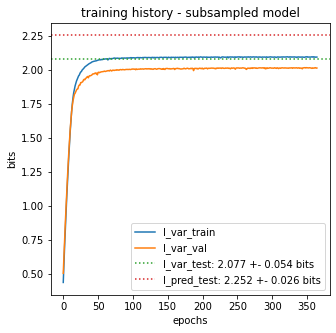

In [21]:
# Show training history
print('On test data:')

# Compute likelihood information
I_var, dI_var =  model.I_variational(x=x_test, y=y_test)
print(f'I_var_test: {I_var:.3f} +- {dI_var:.3f} bits') 

# Compute predictive information
I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[5,5])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.axhline(I_var, color='C2', linestyle=':', label=f'I_var_test: {I_var:.3f} +- {dI_var:.3f} bits')
ax.axhline(I_pred, color='C3', linestyle=':', label=f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training history - subsampled model')
#fig.savefig('results/training_history_and_info_metrics.png',bbox_inches='tight',dpi=300)
#ax.set_ylim([0, I_pred*1.2]);

In [22]:
# # Set wild-type sequence
# gb1_seq = model.x_stats['consensus_seq']

# # Get effects of all single-point mutations on phi
# theta_dict = model.get_theta(gauge='user',
#                              x_wt=gb1_seq)

# # Create two panels
# fig, ax = plt.subplots(1, 1, figsize=[10, 5])

# # Left panel: draw heatmap illustrating 1pt mutation effects
# ax, cb = mavenn.heatmap(theta_dict['theta_lc'],
#                         alphabet=theta_dict['alphabet'],
#                         seq=gb1_seq,
#                         cmap='PiYG',
#                         ccenter=0,
#                         ax=ax)
# ax.set_xlabel('position ($l$)')
# ax.set_ylabel('amino acid ($c$)')
# cb.set_label('effect ($\Delta\phi$)', rotation=-90, va="bottom")
# ax.set_title('mutation effects')

# # Fix up plot

# fig.tight_layout()
# #fig.savefig('results/additive_effects.png',bbox_inches='tight',dpi=300)
# plt.show()


In [26]:
# number_of_double_mutants_used_for_training = len(gb1_subsampled_df.loc[gb1_subsampled_df['set']=='training'])-len(GB1_data_single_mutants)
# print('Number of double mutants used for training small model =',number_of_double_mutants_used_for_training)
# print(f'Percent of double mutants used = {(number_of_double_mutants_used_for_training/len(data_df))*100:.3f}%')

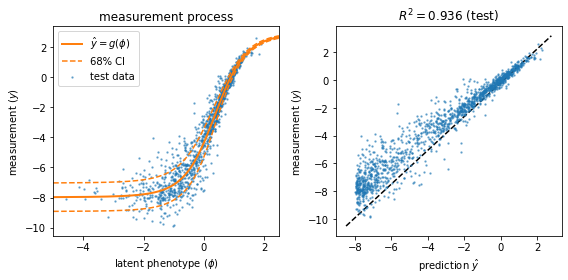

In [24]:
# Compute phi and yhat values
phi_test = model.x_to_phi(x_test)
yhat_test = model.phi_to_yhat(phi_test)

# Create grid for plotting yhat and yqs
phi_lim = [-5, 2.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)
yhat_grid = model.phi_to_yhat(phi_grid)
yqs_grid = model.yhat_to_yq(yhat_grid, q=[.16,.84])

# Create two panels
fig, ax = plt.subplots(1, 2, figsize=[8, 4])

# Illustrate measurement process with GE curve
ax[0].scatter(phi_test, y_test, color='C0', s=2, alpha=.5, label='test data')
ax[0].plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax[0].plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1',
        label='68% CI')
ax[0].plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax[0].set_xlim(phi_lim)
ax[0].set_xlabel('latent phenotype ($\phi$)')
ax[0].set_ylabel('measurement ($y$)')
ax[0].set_title('measurement process')
ax[0].legend()

ax[1].scatter(yhat_test,y_test,s=2,alpha=0.5,c='C0')
ax[1].set_ylabel('measurement ($y$)')
ax[1].set_xlabel('prediction $\hat{y}$')
Rsq = np.corrcoef(y_test,yhat_test)[0][1]**2
ax[1].set_title('$R^2 = $'+str(Rsq)[0:5]+' (test)')
y_lim = ax[1].get_ylim()
x_lim = ax[1].get_xlim()
ax[1].plot(x_lim, y_lim, '--', color = 'black',zorder=0)

# Fix up plot
fig.tight_layout()
#fig.savefig('results/ge_nonlinearity_yhat_vs_y_subsampled_test_rest_of_data.pdf',bbox_inches='tight',dpi=300)
plt.show()